In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sci
from scipy.spatial.distance import cdist
import matplotlib as mpl
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 1.4
Z = 22
FWIDTH = 5
FHEIGHT = 5
n_pts = 100
DPI = 300

In [2]:
#citrate deprotonation state
dp = 3

#in kcal/mol
G_solv_np = 74.9307
G_solv_cit ={"1": -124.68 - 28.91,
            "2": -124.68 - 28.91,
            "3": -124.68 - 28.91} #ELEC + VDW
er_wat = 74.828 

#in nm
R = 1.25

#in molarity
conc_cit = 0.002 #2mM

#in kelvin
T = 310

#in u.m.a
m_prot = 192.124
uma1 = sci.physical_constants['atomic mass constant'][0]

n_pts = 500
n_space = np.linspace(0.1, 60, n_pts)
n_ticks = [0, 15, 30, 45, 60]

In [3]:
def PB_solver_NP(N, I):
    kap = np.sqrt(2*sci.N_A*sci.e**2*I*10**3/(sci.epsilon_0*er_wat*sci.k*T))
    gb = np.exp(-0.73*kap*R*10**-9)
    dg = -(dp*N*sci.e)**2/(8*np.pi*sci.epsilon_0*R*10**-9)*(1-gb/er_wat)
    dg = dg*sci.N_A/4184
    return dg

def PB_solver_CIT(xyz, I):
    kap = np.sqrt(2*sci.N_A*sci.e**2*I*10**3/(sci.epsilon_0*er_wat*sci.k*T))
    dists = cdist(xyz, xyz)
    dists = dists[np.nonzero(np.triu(dists))]
    dg = 0
    prefactor = -1*(sci.e)**2/(8*np.pi*sci.epsilon_0*0.26*10**-9)
    posfactor = 1 - np.exp(-0.73*kap*0.26*10**-9)/er_wat
    g = prefactor*posfactor*sci.N_A/4184
    dg += 3*g #one for every bead
    for d, dist in enumerate(dists):
        f = np.sqrt(dist**2+0.26**2*np.exp(-dist**2/(4*0.26**2)))*10**-9
        prefactor = -1*(sci.e)**2/(8*np.pi*sci.epsilon_0*f)
        posfactor = 1 - np.exp(-0.73*kap*f)/er_wat
        g = prefactor*posfactor*sci.N_A/4184
        dg += g
    return dg

cit = np.array([[1.774, 6.853, 3.819], [1.334, 6.965, 4.075], [1.835, 6.359, 3.821]])

# $\Delta G_1$ Desolvation

In [4]:
def dg1(N):
    G_desolv_np = - G_solv_np
    G_desolv_cit = 124.68 + 28.91 #- G_solv_cit[str(dp)]
    return len(N)*[G_desolv_np], N*G_desolv_cit, N*G_desolv_cit + G_desolv_np

# $\Delta G_2$ Citrate binding in vacuum

In [5]:
def calc_E_bind():
    mult_e_100_ac = {'k': [324, -71.3],
                    'm2': [432, -80.0]}
    
    mult_e_100_glu = {'m4_st': [384, -167.9],
                      'm4_pd': [768, -168.6]}

    mult_e_100_suc = {'m4_st': [384, -168.5],
                      'm4_pd': [768, -171.2]}
    
    mult_e_111_ac = {'m2': [4368, -70.4]}
    
    mult_e_111_glu = {'m4_st': [3456, -148.6],
                      'm4_pd': [8832, -148.6],
                      'm4_bt': [7680, -145.3],
                      'm4_sk': [15360, -146.3]}
    
    mult_e_111_suc = {'m4_st': [3456, -153.7],
                      'm4_pd': [8832, -149.6],
                      'm4_bt': [7680, -150.6],
                      'm4_sk': [15360,-147.4]}
    all_modes = [mult_e_100_ac, mult_e_100_glu, mult_e_100_suc, mult_e_111_ac, mult_e_111_glu, mult_e_111_suc]
    
    Q = 0 #Normalization constant
    e_bind = 0
    for mode in all_modes:
        for value in mode.values():
            value[1] = value[1]*4184
            bweight = value[0]*np.exp(-value[1]/(sci.R*T))
            
            Q += bweight
            e_bind += value[1]*bweight
    e_bind = e_bind/(Q*4184)
    return e_bind   

def rot_entropy(iner):
    extra = 3/2*sci.R
    cons = sci.k*T/(sci.hbar**2)*uma1*10**-18 #to change the units of the moment of inertia
    rot = sci.R*np.log(8*np.prod(iner)*cons**3)
    return -(rot + extra)/4184

def vib_entropy(wavenumber):
    #wavenumber should be in cm-1
    w = 2*np.pi*sci.c*wavenumber*100
    vib = sci.R*(0.5 - np.log(sci.k*T/(sci.hbar*w)))#*4 for each Au-O bond formed
    return vib/4184

def u_pot(N, e_r):
    u = (dp*N*sci.e)**2/(8*np.pi*sci.epsilon_0*e_r*R*10**-9)*sci.N_A/4184
    return u

def dg2(N):
    e_bind = calc_E_bind()

    lamb = np.sqrt(2*np.pi*sci.hbar**2/(sci.k*T*uma1*(m_prot-dp)))
    s_trans = -sci.R*(np.log(10**-3/(conc_cit*sci.N_A*lamb**3)) + 2.5)/4184
    s_rot = rot_entropy([3.724, 8.646, 9.495]) #moments of inertia from citrate AA-MD
    s_vib = vib_entropy(1638) 
    s_bind = s_trans + s_rot + s_vib

    e_citcit = u_pot(N,1) - N*u_pot(1,1)

    e2 = N*e_bind - N*T*s_bind + e_citcit
    return N*e_bind, N*T*s_bind, e_citcit, e2

# $\Delta G_3$ Solvation of $M(Cit)_N$ complex

In [6]:
def dg3(N):
    e_solv_elec = u_pot(N, er_wat) - u_pot(N, 1)
    e3 = G_solv_np + e_solv_elec

    return len(N)*[G_solv_np], e_solv_elec, G_solv_np + e_solv_elec

# $\Delta G_4$ Citrate binding in solution

In [7]:
def dg4(N):
    return dg1(N)[-1] + dg2(N)[-1] + dg3(N)[-1]

Estimated number of bound citrate molecules: 33.2


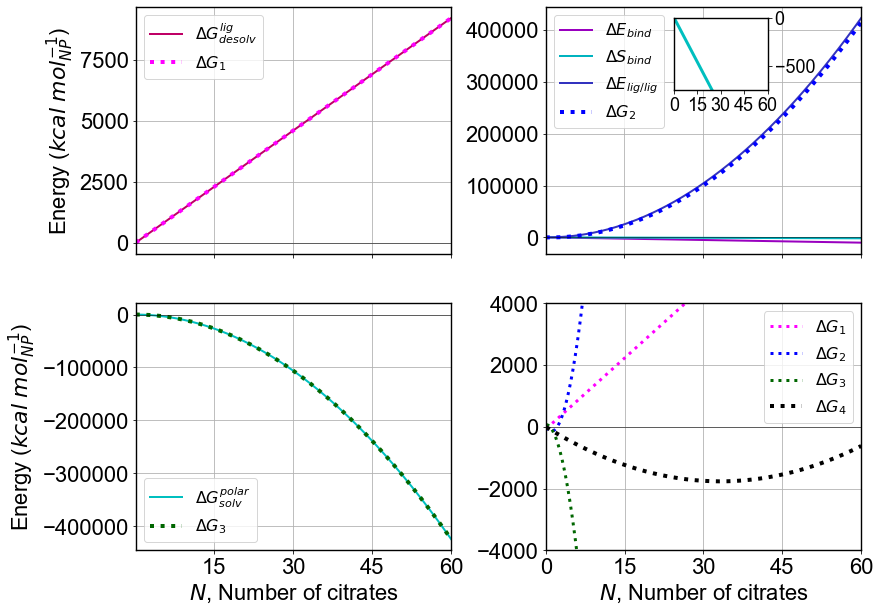

In [8]:
c1 = [(0.4, 0, 0.75),(0.75, 0, 0.4),(1.0, 0, 1.0)]
c2 = [(0.6, 0, 0.75),(0, 0.7, 0.75),(0.2, 0.2, 0.75),(0, 0, 1)]
c3 = [(0.75, 0.75, 0),(0, 0.75, 0.75),(0.0, 0.4, 0.0)]

fig, axs = plt.subplots(figsize=(2*FWIDTH+3, 2*FHEIGHT), nrows=2, ncols=2, sharex=True, gridspec_kw={'wspace':0.3})
axs[0,0].set_ylabel(r"Energy ($kcal$ $mol^{-1}_{NP}$)", fontsize=Z)
axs[1,0].set_ylabel(r"Energy ($kcal$ $mol^{-1}_{NP}$)", fontsize=Z)
axs[1,0].set_xlabel("$N$, Number of citrates", fontsize=Z)
axs[1,1].set_xlabel("$N$, Number of citrates", fontsize=Z)

#axs[0,0].plot(n_space, dg1(n_space)[0], lw=2, c=c1[0], label="$\Delta G_{desolv}^M$")
axs[0,0].plot(n_space, dg1(n_space)[1], lw=2, c=c1[1], label="$\Delta G_{desolv}^{lig}$")
axs[0,0].plot(n_space, dg1(n_space)[1], lw=4, c=c1[2], label="$\Delta G_1$", ls=':')
axs[0,0].legend(loc='upper left', fontsize=Z-6)#, bbox_to_anchor=(1, 1.04))

axs[0,1].plot(n_space, dg2(n_space)[0], lw=2, c=c2[0], label="$\Delta E_{bind}$")
axs[0,1].plot(n_space, dg2(n_space)[1], lw=2, c=c2[1], label="$\Delta S_{bind}$")
axs[0,1].plot(n_space, dg2(n_space)[2], lw=2, c=c2[2], label="$\Delta E_{lig/lig}$")
axs[0,1].plot(n_space, dg2(n_space)[3], lw=4, c=c2[3], label="$\Delta G_2$", ls=':')
axs[0,1].legend(loc='upper left', fontsize=Z-6)#, bbox_to_anchor=(1, 1.04))
ax1 = plt.axes((0.7, 0.765, 0.1,0.1))
ax1.tick_params(labelsize=Z-4)
ax1.set_xticks(n_ticks)
#ax1.set_yticks([0,2.5, 5, 7.5])
ax1.plot(n_space, dg2(n_space)[1], lw=3, c='c')
ax1.yaxis.tick_right()
ax1.set_xlim((0,max(n_space)))
ax1.set_ylim((-750,0))

#axs[1,0].plot(n_space, dg3(n_space)[0], lw=2, c=c3[0], label="$\Delta G_{apolar}^{M(lig)_N}$")
axs[1,0].plot(n_space, dg3(n_space)[1], lw=2, c=c3[1], label="$\Delta G_{solv}^{polar}$")
axs[1,0].plot(n_space, dg3(n_space)[2], lw=4, c=c3[2], label="$\Delta G_3$", ls=':')
axs[1,0].legend(loc='lower left', fontsize=Z-6)#, bbox_to_anchor=(1, 1.04))

axs[1,1].plot(n_space, dg1(n_space)[-1], lw=3, c=c1[-1], label="$\Delta G_1$", ls=':')
axs[1,1].plot(n_space, dg2(n_space)[-1], lw=3, c=c2[-1], label="$\Delta G_2$", ls=':')
axs[1,1].plot(n_space, dg3(n_space)[-1], lw=3, c=c3[-1], label="$\Delta G_3$", ls=':')
axs[1,1].plot(n_space, dg4(n_space), lw=4, c='k', label="$\Delta G_4$", ls=':')
axs[1,1].set_ylim((-4000, 4000))
#plt.tight_layout()
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules: {:.1f}".format(N_CIT))
axs[1,1].legend(loc='upper right', fontsize=Z-6)#, bbox_to_anchor=(1, 1.04))

for ax in axs.flatten():
    ax.tick_params(labelsize=Z)
    ax.set_xlim(min(n_space), max(n_space))
    ax.set_xticks(n_ticks)
    ax.grid()
    ax.axhline(y=0,c='k', lw=0.5)
    
#plt.savefig('dg1.png', format='png', dpi=DPI, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

Estimated number of bound citrate molecules: 33.2


<ipython-input-9-7d2cb340f853>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


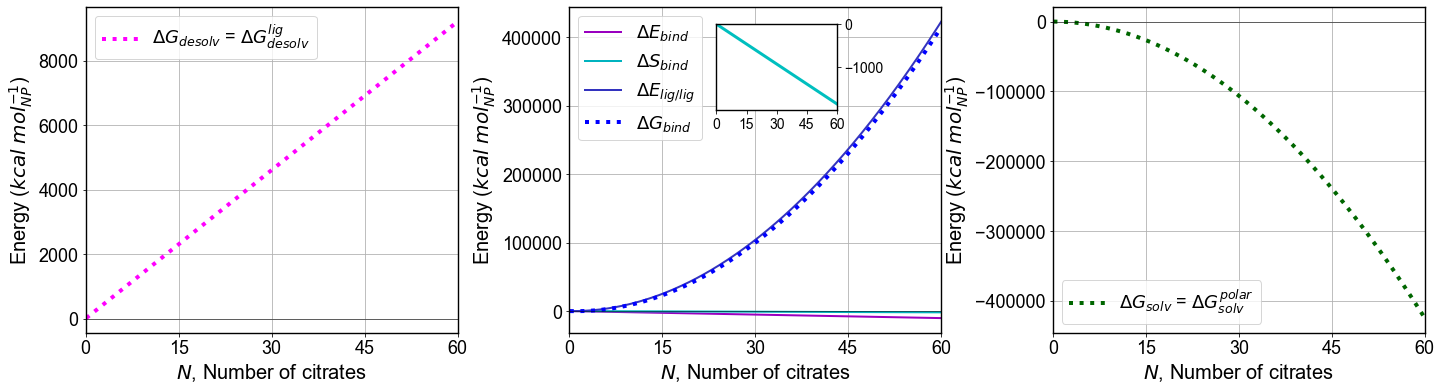

In [9]:
c1 = [(0.4, 0, 0.75),(0.75, 0, 0.4),(1.0, 0, 1.0)]
c2 = [(0.6, 0, 0.75),(0, 0.7, 0.75),(0.2, 0.2, 0.75),(0, 0, 1)]
c3 = [(0.75, 0.75, 0),(0, 0.75, 0.75),(0.0, 0.4, 0.0)]
Z=18
fig, axs = plt.subplots(figsize=(24,6), nrows=1, ncols=3, gridspec_kw={'wspace':0.3})
for ax in axs:
    ax.set_ylabel(r"Energy ($kcal$ $mol^{-1}_{NP}$)", fontsize=Z+2)
    ax.set_xlabel("$N$, Number of citrates", fontsize=Z+2)

#axs[0].plot(n_space, dg1(n_space)[0], lw=2, c=c1[0], label="$\Delta G_{desolv}^M$")
#axs[0].plot(n_space, dg1(n_space)[1], lw=2, c=c1[1], label="$\Delta G_{desolv}^{lig}$")
axs[0].plot(n_space, dg1(n_space)[1], lw=4, c=c1[2], label="$\Delta G_{desolv}$ = $\Delta G_{desolv}^{lig}$", ls=':')
axs[0].legend(loc='upper left', fontsize=Z)#, bbox_to_anchor=(1, 1.04))

axs[1].plot(n_space, dg2(n_space)[0], lw=2, c=c2[0], label="$\Delta E_{bind}$")
axs[1].plot(n_space, dg2(n_space)[1], lw=2, c=c2[1], label="$\Delta S_{bind}$")
axs[1].plot(n_space, dg2(n_space)[2], lw=2, c=c2[2], label="$\Delta E_{lig/lig}$")
axs[1].plot(n_space, dg2(n_space)[3], lw=4, c=c2[3], label="$\Delta G_{bind}$", ls=':')
axs[1].legend(loc='upper left', fontsize=Z)#, bbox_to_anchor=(1, 1.04))
ax1 = plt.axes((0.49, 0.64, 0.07,0.2))
ax1.tick_params(labelsize=Z-4)
ax1.set_xticks(n_ticks)
#ax1.set_yticks([0,2.5, 5, 7.5])
ax1.plot(n_space, dg2(n_space)[1], lw=3, c='c')
ax1.yaxis.tick_right()
ax1.set_xlim((0,max(n_space)))
ax1.set_ylim((-2000,0))
ax1.set_yticks([0,-1000])

#axs[2].plot(n_space, dg3(n_space)[0], lw=2, c=c3[0], label="$\Delta G_{apolar}^{M(Cit)_N}$")
#axs[2].plot(n_space, dg3(n_space)[1], lw=2, c=c3[1], label="$\Delta G_{solv}^{polar}$")
axs[2].plot(n_space, dg3(n_space)[2], lw=4, c=c3[2], label="$\Delta G_{solv}$ = $\Delta G_{solv}^{polar}$", ls=':')
axs[2].legend(loc='lower left', fontsize=Z)#, bbox_to_anchor=(1, 1.04))

"""axs[1,1].plot(n_space, dg1(n_space)[-1], lw=3, c=c1[-1], label="$\Delta G_1$", ls=':')
axs[1,1].plot(n_space, dg2(n_space)[-1], lw=3, c=c2[-1], label="$\Delta G_2$", ls=':')
axs[1,1].plot(n_space, dg3(n_space)[-1], lw=3, c=c3[-1], label="$\Delta G_3$", ls=':')
axs[1,1].plot(n_space, dg4(n_space), lw=4, c='k', label="$\Delta G_4$", ls=':')
axs[1,1].set_ylim((-4000, 4000))"""
#plt.tight_layout()
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules: {:.1f}".format(N_CIT))
#axs[1,1].legend(loc='upper right', fontsize=Z-6)#, bbox_to_anchor=(1, 1.04))

for ax in axs:
    ax.tick_params(labelsize=Z)
    ax.set_xlim(min(n_space), max(n_space))
    ax.set_xticks(n_ticks)
    ax.grid()
    ax.axhline(y=0,c='k', lw=0.5)
plt.tight_layout()
#plt.savefig('dg_terms.png', format='png', dpi=DPI, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('dg_terms.png', format='png', dpi=DPI)
plt.show()
plt.close()

Estimated number of bound citrate molecules (alpha=3): 33.2. -1764.40
Estimated number of bound citrate molecules (alpha=2): 27.9. -556.79
Estimated number of bound citrate molecules (alpha=1): 0.1. 0.01


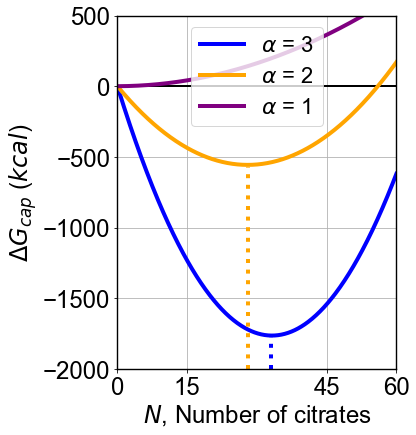

In [38]:
Z=24
fig = plt.figure(figsize = (5,6.5))
ax = plt.axes()
ax.set_ylabel(r"$\Delta G_{cap}$ ($kcal$)", fontsize=Z)
ax.set_xlabel("$N$, Number of citrates", fontsize=Z)
ax.tick_params(labelsize=Z)
ax.set_xlim(min(n_space), max(n_space))
#ax.set_xticks(n_ticks)
ax.set_xticks([0,15,45,60])
#ax.grid()
ax.axhline(y=0,c='k', lw=2)
dp=3
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='b', label=r"$\alpha$ = 3", ls='-')
dp=2
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='orange', label=r"$\alpha$ = 2", ls='-')
dp=1
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='purple', label=r"$\alpha$ = 1", ls='-')
ax.axvline(x=28, ymin=0, ymax=0.57, lw=4, c='orange', ls=':')
ax.axvline(x=33, ymin=0, ymax=0.1, lw=4, c='b', ls=':')
ax.set_ylim((-2000, 500))
ax.grid()

lgd = ax.legend(loc='upper center', fontsize=Z-2)#, bbox_to_anchor=(1.6, 1.08))    
plt.savefig("dg_cap.png", format='png', dpi=DPI, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [31]:
for dp in np.linspace(2.6,2.7,20):
    gibbs = dg4(n_space)
    ndx = np.argmin(gibbs)
    print("alpha={:.2f}: {:.1f} Cit. {:.1f} kcal/mol".format(dp, n_space[ndx], gibbs[ndx]/n_space[ndx]))

alpha=2.60: 31.8 Cit. -38.3 kcal/mol
alpha=2.61: 31.9 Cit. -38.3 kcal/mol
alpha=2.61: 31.9 Cit. -38.6 kcal/mol
alpha=2.62: 31.9 Cit. -38.8 kcal/mol
alpha=2.62: 31.9 Cit. -39.0 kcal/mol
alpha=2.63: 31.9 Cit. -39.2 kcal/mol
alpha=2.63: 32.0 Cit. -39.2 kcal/mol
alpha=2.64: 32.0 Cit. -39.5 kcal/mol
alpha=2.64: 32.0 Cit. -39.7 kcal/mol
alpha=2.65: 32.0 Cit. -39.9 kcal/mol
alpha=2.65: 32.0 Cit. -40.1 kcal/mol
alpha=2.66: 32.0 Cit. -40.3 kcal/mol
alpha=2.66: 32.2 Cit. -40.4 kcal/mol
alpha=2.67: 32.2 Cit. -40.6 kcal/mol
alpha=2.67: 32.2 Cit. -40.8 kcal/mol
alpha=2.68: 32.2 Cit. -41.0 kcal/mol
alpha=2.68: 32.2 Cit. -41.2 kcal/mol
alpha=2.69: 32.3 Cit. -41.3 kcal/mol
alpha=2.69: 32.3 Cit. -41.5 kcal/mol
alpha=2.70: 32.3 Cit. -41.7 kcal/mol


Estimated number of bound citrate molecules (alpha=1): 0.1. 0.01
Estimated number of bound citrate molecules (alpha=2): 27.9. -556.79
Estimated number of bound citrate molecules (alpha=3): 33.2. -1764.40


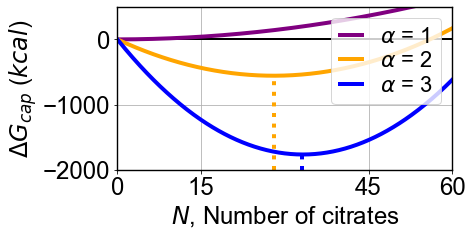

In [11]:
Z=24
fig = plt.figure(figsize = (6,3))
ax = plt.axes()
ax.set_ylabel(r"$\Delta G_{cap}$ ($kcal$)", fontsize=Z)
ax.set_xlabel("$N$, Number of citrates", fontsize=Z)
ax.tick_params(labelsize=Z)
ax.set_xlim(min(n_space), max(n_space))
#ax.set_xticks(n_ticks)
ax.set_xticks([0,15,45,60])
#ax.grid()
ax.axhline(y=0,c='k', lw=2)
dp=1
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='purple', label=r"$\alpha$ = 1", ls='-')
dp=2
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='orange', label=r"$\alpha$ = 2", ls='-')
dp=3
N_CIT = n_space[np.argmin(dg4(n_space))]
print("Estimated number of bound citrate molecules (alpha={:d}): {:.1f}. {:.2f}".format(dp, N_CIT, np.min(dg4(n_space))))
ax.plot(n_space, dg4(n_space), lw=4, c='b', label=r"$\alpha$ = 3", ls='-')
ax.axvline(x=28, ymin=0, ymax=0.57, lw=4, c='orange', ls=':')
ax.axvline(x=33, ymin=0, ymax=0.1, lw=4, c='b', ls=':')
ax.set_ylim((-2000, 500))
ax.grid()

lgd = ax.legend(loc='upper right', fontsize=Z-2, labelspacing=0.2, handlelength=1)#, bbox_to_anchor=(1.6, 1.08))    
plt.savefig("dg_cap.png", format='png', dpi=DPI, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()